In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/dl_asnmt3/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/dl_asnmt3
/content/drive/MyDrive/dl_asnmt3


In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import *
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision import datasets
from torchvision import models
from torch.optim import lr_scheduler
import os
import time
import gc
import shutil
import h5py
import random
%matplotlib inline

## Sequence generator function

In [ ]:
def generate_seq():
    p = 100
    onehotemb = np.eye(p+1)
    sq = []
    setno = random.randint(0,1)
    # print(setno)
    c = onehotemb[p-1+setno]
    sq.append(c)

    prev=0
    for i in range(p-1):
        # r = random.randint(prev,p-2)
        r = random.randint(1,p-2)
        # print(r+1)
        emb = onehotemb[r]
        sq.append(emb)
        prev = r

    seq = torch.tensor(sq, dtype=torch.float32)
    last = torch.tensor((p+setno),dtype=int)
    return seq, last

a, b = generate_seq()
print(a.shape, b.shape)

torch.Size([100, 101]) torch.Size([])


## Common utility functions  
The testing criteria is same as given in the question : 10 trails of 3000 sequences

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_checkpoint(state, is_best, epoch, name):
    filename = 'q3_checkpoints/q3_ckpt_'+name
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, filename+'_best')

def test_model(model_class, ckpt):
    model = model_class().cuda()
    print(model)
    checkpoint = torch.load('q3_checkpoints/'+ckpt)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model_accuracy = 0
    total_wrong = 0
    smax = nn.Softmax(dim=1)
    for trial in range(10):
        correct = 0
        wrong = 0
        for i in range(3000):
            inputs, labels = generate_seq()
            # print(labels.shape, labels)
            inputs = inputs.unsqueeze(0).cuda()
            labels = labels.unsqueeze(0).cuda()
            label_emb = [0 for j in range(101)]
            label_emb[labels.item()-1] = 1
            label_emb = torch.tensor(label_emb).unsqueeze(0).cuda()
            # print(label_emb.shape)
            with torch.set_grad_enabled(True):
                # print(type(inputs), inputs)
                outputs = model(inputs)
                # print(outputs.shape)
                # print(outputs)
                out = torch.argmax(outputs, dim=1)
                # total_correct += (outputs == labels).sum().item()
                if out != labels-1:
                    wrong += 1
                outputs = smax(outputs)
                # print(torch.abs(label_emb - outputs))
                if (torch.abs(label_emb - outputs) >= 0.3).sum().item() == 0:
                    correct += 1
            torch.cuda.empty_cache()
            gc.collect()
        accuracy = correct/3000*100
        print('Trial',trial,'==>\t Accuracy :',accuracy,'%\t','Wrong predictions :',wrong,'/ 3000')
        model_accuracy += accuracy
        total_wrong += wrong
    print('Avg accuracy :',model_accuracy/10,'\t Avg wrong predictions :',total_wrong/10)
    # return model_accuracy, total_wrong

def plot_train(losses):
    seqdone = [i*1000 for i in range(len(losses))]
    plt.plot(seqdone, losses, label = "Train loss", color='blue')#, markersize=5, marker='o',markerfacecolor='blue')
    plt.xlabel('Number of training sequences')
    plt.ylabel('Loss')
    plt.title('Train loss vs. number of sequences')
    plt.legend()
    plt.show()

## Common trainer class

The model is given first 100 numbers (1-hot vectors) of the sequence as input and it learns to predict the next (101st) number (1-hot vector)  
The 101st (predicted) number should be equal to the 1st number in the sequence  
Thus the model should learn long term dependency (last number only depends on the 1st number)

In [ ]:
class Trainer(object):
    def __init__(self, device, model_class, ckpt_name, load_ckpt=None, epochs=100, batch_size=1, lr=0.1, optm='adam', lr_decay=None, weight_decay=0):
        self.device = device
        self.lr =  lr
        self.momentum = 0.9
        self.lr_decay = lr_decay
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.start_epoch = 0
        self.epochs = epochs
        self.itrs = 500
        self.seed = int(time.time())
        self.checkpoint_path = load_ckpt 
        self.best_epoch = 0
        self.best_loss = 1e8
        self.ckpt_name = ckpt_name
        self.loss_history = []
        self.error_history = []
        torch.cuda.manual_seed(self.seed)
        print(self.device,torch.cuda.get_device_name(0))

        self.model = model_class().cuda()
        print(self.model)
        if optm=='sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        elif optm=='adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr)
        self.criterion = nn.CrossEntropyLoss().cuda()
        
        if self.checkpoint_path:
            checkpoint = torch.load('q3_checkpoints/'+self.checkpoint_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.start_epoch = checkpoint['epoch']+1
            self.best_loss = checkpoint['best_loss']
            self.best_epoch = checkpoint['best_epoch']
        
    def train(self):
        acc = 0
        fullacc = 0
        for epoch in range(self.start_epoch, self.epochs):
            loss, acc = self.train_epoch(epoch)
            if acc==100:
                fullacc += 1
            else:
                fullacc = 0
            if loss < self.best_loss:
                is_best = True
                self.best_epoch = epoch
            else:
                is_best = False
            seqdone = (epoch+1)*self.itrs
            self.loss_history.append(loss)
            self.best_loss = min(loss, self.best_loss)
            print('Sequences:'+str(seqdone),'  Loss:'+str(round(loss,3)),'  Accuracy:'+str(round(acc,3)))
            save_checkpoint({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'best_loss': self.best_loss,
                'best_epoch': self.best_epoch
            }, is_best, epoch, self.ckpt_name)
            if fullacc==4 and loss<0.1:
                break
            # input()
        return self.best_epoch, self.loss_history

    def train_epoch(self, cur_epoch):    
        self.model.train()        
        losses = 0
        # itrs = 1000
        total_correct = 0
        smax = nn.Softmax(dim=1)
        for i in range(self.itrs):
            inputs, labels = generate_seq()
            # print(labels.shape, labels)
            inputs = inputs.unsqueeze(0).to(self.device)
            labels = labels.unsqueeze(0).to(self.device)
            label_emb = [0 for j in range(101)]
            label_emb[labels.item()-1] = 1
            label_emb = torch.tensor(label_emb).unsqueeze(0).cuda()
            # print(label_emb.shape)
            with torch.set_grad_enabled(True):
                # print(type(inputs), inputs)
                outputs = self.model(inputs)
                # print(outputs.shape)
                # print(outputs)
                loss = self.criterion(outputs, labels-1)
                # print(loss)
                losses += loss.detach().cpu().item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                # labels = labels.item()
                # outputs = torch.argmax(outputs, dim=1)
                # total_correct += (outputs == labels).sum().item()
                outputs = smax(outputs)
                # print(torch.abs(label_emb - outputs))
                if (torch.abs(label_emb - outputs) >= 0.3).sum().item() == 0:
                    total_correct += 1
            torch.cuda.empty_cache()
            gc.collect()
        return losses/self.itrs, total_correct/self.itrs*100

Accuracy and stopping criteria used is as given in the 4th question  
It uses Adam optimizer to train where the loss is calculated and backpropagated at every training instance (stochastic)  
At each iteration, a random sequence is generated as told in the question  
Loss and acuracies are printed after training on every 500 sequences

## 1-Layer LSTM : input_size=101, output_size=101, hidden_dim=101

In [ ]:
class MyLSTM(nn.Module):
    def __init__(self, input_size=101, output_size=101, hidden_dim=101, n_layers=1):
        super(MyLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm1 = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        # print(x.shape)
        out, (hidden, cell) = self.lstm1(x)
        output = hidden
        # print(output.shape)
        output = self.fc(output)
        # print(output.shape)
        output = output.squeeze(0)
        return output

### Training LSTM

cuda Tesla T4
MyLSTM(
  (lstm1): LSTM(101, 101, batch_first=True)
  (fc): Linear(in_features=101, out_features=101, bias=True)
)
Sequences:500   Loss:2.361   Accuracy:33.2
Sequences:1000   Loss:0.01   Accuracy:99.6
Sequences:1500   Loss:0.003   Accuracy:100.0
Sequences:2000   Loss:0.322   Accuracy:96.2
Sequences:2500   Loss:0.0   Accuracy:100.0
Sequences:3000   Loss:0.0   Accuracy:100.0
Sequences:3500   Loss:0.0   Accuracy:100.0
Sequences:4000   Loss:0.0   Accuracy:100.0


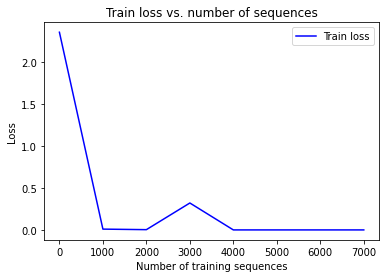

Best epoch: 7


In [ ]:
lstm1_trainer = Trainer(device, MyLSTM, 'lstm1', lr=0.1, epochs=100)
lstm1_best_epoch, lstm1_losses = lstm1_trainer.train()
plot_train(lstm1_losses)
print('Best epoch:',lstm1_best_epoch)

### Testing LSTM

In [ ]:
test_model(MyLSTM,'q3_ckpt_lstm1')

MyLSTM(
  (lstm1): LSTM(101, 101, batch_first=True)
  (fc): Linear(in_features=101, out_features=101, bias=True)
)
Trial 0 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 1 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 2 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 3 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 4 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 5 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 6 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 7 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 8 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 9 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Avg accuracy : 100.0 	 Avg wrong predictions : 0.0


We can observe that the 1-layer LSTM learns the sequence quickly and ends up with exactly 0 loss on trainset after learning 4000 sequences. Even on the unseen test data it gives 100% accuracy on all 10 trails with no wrong predictions

## 1-Layer RNN : input_size=101, output_size=101, hidden_dim=101

In [ ]:
class MyRNN1(nn.Module):
    def __init__(self, input_size=101, output_size=101, hidden_dim=101, n_layers=1):
        super(MyRNN1, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn1 = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        # print(x.shape)
        out, hidden = self.rnn1(x)
        output = hidden
        # print(output.shape)
        output = self.fc(output)
        # print(output.shape)
        output = output.squeeze(0)
        return output

### Training RNN

cuda Tesla T4
MyRNN1(
  (rnn1): RNN(101, 101, batch_first=True)
  (fc): Linear(in_features=101, out_features=101, bias=True)
)
Sequences:500   Loss:850.192   Accuracy:4.4
Sequences:1000   Loss:0.703   Accuracy:0.0
Sequences:1500   Loss:0.697   Accuracy:0.0
Sequences:2000   Loss:0.698   Accuracy:0.0
Sequences:2500   Loss:13260930.027   Accuracy:1.8
Sequences:3000   Loss:0.695   Accuracy:0.0
Sequences:3500   Loss:0.694   Accuracy:0.8
Sequences:4000   Loss:2.34   Accuracy:3.2
Sequences:4500   Loss:27.342   Accuracy:42.6
Sequences:5000   Loss:0.704   Accuracy:60.4
Sequences:5500   Loss:0.142   Accuracy:93.2
Sequences:6000   Loss:0.107   Accuracy:99.0
Sequences:6500   Loss:0.078   Accuracy:99.8
Sequences:7000   Loss:0.057   Accuracy:100.0
Sequences:7500   Loss:0.041   Accuracy:100.0
Sequences:8000   Loss:0.033   Accuracy:100.0
Sequences:8500   Loss:0.022   Accuracy:100.0


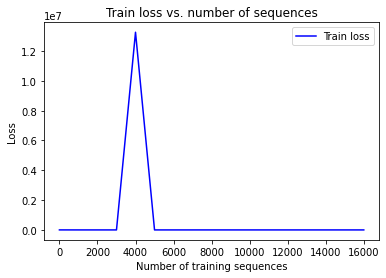

Best epoch: 16


In [ ]:
rnn1_trainer = Trainer(device, MyRNN1, 'rnn1', lr=0.001, epochs=100)
rnn1_best_epoch, rnn1_losses = rnn1_trainer.train()
plot_train(rnn1_losses)
print('Best epoch:',rnn1_best_epoch)

### Testing RNN

In [ ]:
test_model(MyRNN1,'q3_ckpt_rnn1')

MyRNN1(
  (rnn1): RNN(101, 101, batch_first=True)
  (fc): Linear(in_features=101, out_features=101, bias=True)
)
Trial 0 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 1 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 2 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 3 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 4 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 5 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 6 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 7 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 8 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Trial 9 ==>	 Accuracy : 100.0 %	 Wrong predictions : 0 / 3000
Avg accuracy : 100.0 	 Avg wrong predictions : 0.0


As we can see, 1-layer RNN took more sequences to train and was unstable as opposed to LSTM. Even the training loss is not exactly 0. Though at the test time, RNN is able to make correct predictions. This result is for RNN with Relu nonlinearity. Default TanH nonlinearity did not work (at least for the several learning rates I tried)  
  
Concluding, LSTM works better in capturing long term dependencies